> ## **Métodos Computacionales II - Taller #1**

**Hecho por:** Thomas Andrade Hernández (202214695) & Juan Carlos Rojas V. (202214037)

In [6]:
# Zona de librerías:

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import random as rnd

> **Sección 2.9:**

**1.** Muestre que los siguientes operadores diferenciales:

$$f'(x) = \frac{-f(x + 2h) + 4f(x + h) - 3f(x)}{2h}$$

$$f''(x) = \frac{f(x + h) - 2f(x) + f(x - h)}{h^{2}}$$

son consistentes. Use como funciones de prueba $f(x) = x^{2}$ y $f(x) = sin(x)$.

***

**2.** Usando el código de la clase, genere 10 esferas localizadas aleatoriamente en la mesa A = 40 × 40 con velocidad aleatorias entre $−5$ m/s y $5$ m/s. Simule $10$ s con un paso de integración de $h = 0.001$ s y reduzca la simulación en un factor de 200; quitando la interacción con la pared. Conteste las siguientes preguntas exponiendo los conceptos físicos involucrados.

In [7]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        # Atributos instantaneos:
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.f = self.m*self.a
        
        # Historial:
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)
    
        # Física:
        
        self.K = 20.
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Algoritmo de Euler:
        
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            Fn = self.K * compresion**3
            self.n = (self.r - p.r)/d
            self.f = Fn*self.n            
        
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        self.V[i] = self.v
        self.P[i] = self.m*self.v
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]

In [8]:
def GetParticles(N,t):
    
    Particles = []

    for i in range(N):
        r0 = np.array([float(rnd.randrange(-15,15)), float(rnd.randrange(-15,15))])
        v0 = np.array([float(rnd.randrange(-5,5)), float(rnd.randrange(-5,5))])
        a0 = np.array([0.,0.])
        Particles.append(Particle(r0,v0,a0,t))
    
    return Particles

In [9]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [10]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Trust me. Let me cook', unit=' Steps'):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j]) 
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            
            
    return Particles

In [11]:
Particles = RunSimulation(t,Particles)

Trust me. Let me cook: 100%|████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 525.71 Steps/s]


In [12]:
scale = 200
t_ = t[::scale]

<IPython.core.display.Javascript object>


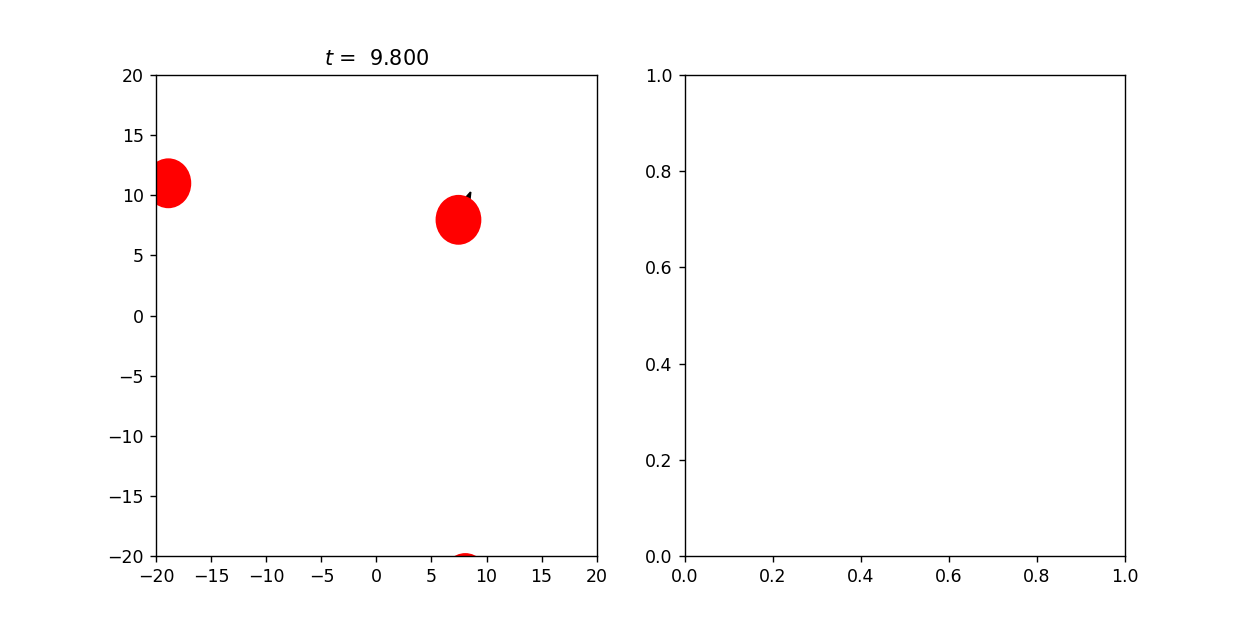

In [131]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r'$t$ =  %.3f' %(t_[i]))
    
    for p in Particles:
        
        x = p.GetPosition(scale=100)[i,0]
        y = p.GetPosition(scale=100)[i,1]
        
        vx = p.GetVelocity(scale=100)[i,0]
        vy = p.GetVelocity(scale=100)[i,1]
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5) # Se ve más bonito con la flecha dentro del círculo. :3
        circle = plt.Circle( (x,y), p.radius, color='r', fill= True)
        ax.add_patch(circle)
        
    
Animation = anim.FuncAnimation(fig,Update,frames=len(t),init_func=init)


***

**4.** Usando el código visto en clase, comprobar la tercera Ley de Kepler para todos los planetas del sistema solar (hasta la órbita de Júpiter). Usando un paso temporal adecuado ($\Delta t = 0.001$). Tomar los semiejes mayores y excentricidad de internet.

> **Solución:**

In [91]:
class Planeta:
    
    def __init__(self,name, e, a, t):
        self.name = name
        self.t = t
        self.dt = t[1] - t[0] # Paso del tiempo
        
        self.e = e # Excentricidad
        self.a_ = a # Semi-eje mayor
        
        self.G = 4*np.pi**2 # Unidades gaussianas
        
        self.r = np.zeros(3)
        self.v = np.zeros_like(self.r)
        self.a = np.zeros_like(self.r)
        
        self.r[0] = self.a_*(1-self.e)
        self.v[1] = np.sqrt( self.G*(1+self.e)/(self.a_*(1.-self.e)) )
        
        self.R = np.zeros((len(t),len(self.r)))
        self.V = np.zeros_like(self.R)
        self.period = 0
        
        # El valor del pasado
        self.rp = self.r
        
    def GetAceleration(self):
        
        d = np.linalg.norm(self.r)
        self.a = -self.G/d**3*self.r
        
        
    def Evolution(self,i):
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.GetAceleration()
        
        if i==0:
            self.r = self.rp + self.v*self.dt
        else:
            
            # rp pasado, r presente rf futuro
            self.rf = 2*self.r - self.rp + self.a*self.dt**2
            self.v = (self.rf - self.rp)/(2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
    
    def SetPosition(self,i):
        self.R[i] = self.r
        
    def SetVelocity(self,i):
        self.V[i] = self.v
    
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
    
    def GetPerihelio(self):
        
        Dist = np.linalg.norm(self.R,axis=1)
        timeup = []
        
        for i in range(1,len(Dist)-1):
            if Dist[i] < Dist[i-1] and Dist[i] < Dist[i+1]:
                timeup.append(self.t[i])
        self.period = timeup[1]-timeup[0]
        return timeup



In [92]:
def RunSimulation(t,Planetas):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        #print(it)
        for i in range(len(Planetas)):
            Planetas[i].Evolution(it)            
            
    return Planetas

dt = 0.001
tmax = 32
t = np.arange(0.,tmax,dt)

 **a.** Tome los semiejes mayores y excentricidad de internet.

In [93]:
names = ["Mercurio","Venus","Tierra","Marte"]
exc = np.array([0.2056,0.0068,0.0167,0.0934,0.0483])
semiaxs = np.array([0.387098,0.723327,1.00,1.523679,5.204267])


def GetPlanetas(t):
    p=[]
    for i in range(len(names)):
        p.append(Planeta(names[i],exc[i],semiaxs[i],t))
    return p

**b.** Calcule el periodo de la órbita usando el perihelio o el afelio.

In [98]:
Planetas = GetPlanetas(t)
Planetas = RunSimulation(t,Planetas)


for i in range(len(names)):
    Planetas[i].GetPerihelio()
    print("El período de %s  es de %s años"%(names[i],round(Planetas[i].period,3)))

Running simulation: 100%|██████████████████████████████████████████████████| 32000/32000 [00:04<00:00, 6790.30 Steps/s]

El período de Mercurio  es de 0.241 años
El período de Venus  es de 0.615 años
El período de Tierra  es de 1.0 años
El período de Marte  es de 1.881 años


**c.** Grafique el período al cuadrado en función del semieje mayor al cubo de cada planeta.

<IPython.core.display.Javascript object>


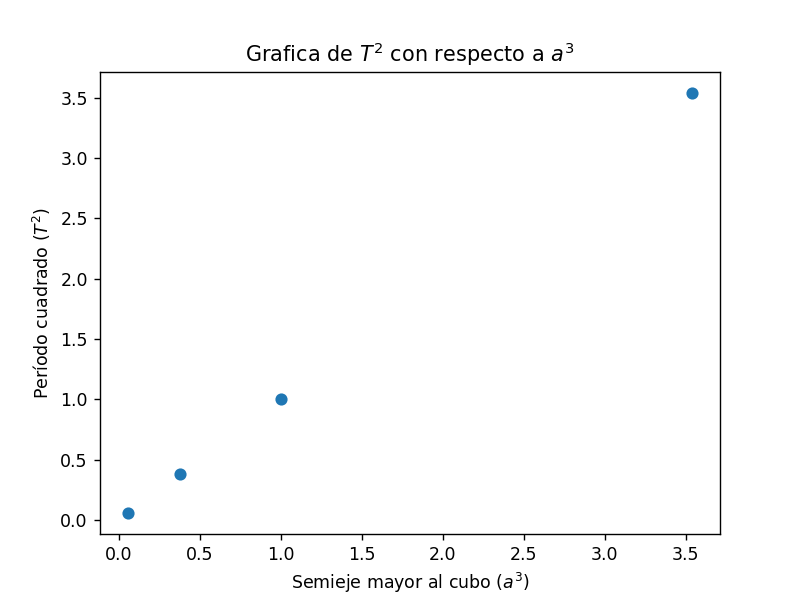

In [110]:
sqrd_T = np.zeros(len(names))
cbd_a = np.zeros(len(names))
for i in range(len(Planetas)):
    sqrd_T[i] = Planetas[i].period**2
    cbd_a[i] = Planetas[i].a_**3
plt.title(r"Grafica de $T^2$ con respecto a $a^3$")  
plt.ylabel(r"Período cuadrado ($T^2$)")
plt.xlabel(r"Semieje mayor al cubo ($a^3$)")
plt.scatter(cbd_a,sqrd_T)
    

**d.** Usando el curso de métodos I, haga una regresión lineal para encontrar la pendiente y punto de corte de la regresión.

In [116]:
m,b = np.polyfit(cbd_a,sqrd_T,1)
print("Pendiente de: %s \nPunto de corte: %s"%(m,b))

Pendiente de: 1.000256328399835 
Punto de corte: -0.00015708203897069065


**e.** Con el valor de la pendiente, reporte la masa del Sol en unidades gausianas y en el sistema internacional.

Teniendo en cuenta que el período de un planeta se puede describir como $$T^2 = \frac{4\pi^2}{GM}a^3$$ que en unidades guasianas está dado por $$T^2 = M_{\odot}^{-1}a^3.$$ Por lo que, dado que ya se tiene la razón $\frac{T^2}{a^3}$, entonces la pendiente $m$ será el inverso de la masa solar. Esto es:

In [128]:
solar_mass_gauss = 1/m
solar_mass_IS = solar_mass*(1.989e30)
print(r"Masa solar en unidades gausianas: %s masas solares."%(round(solar_mass_gauss,5)))
print(r"Masa solar en uniadades internacionales: %s kg."%(solar_mass_IS))

Masa solar en unidades gausianas: 0.99974 masas solares.
Masa solar en uniadades internacionales: 1.9884902934649888e+30 kg.


***

**7. Numerical quantum mechanics**
Considere el siguiente problema de valores y vectores propios:
$$\frac{\text{d}^2y}{\text{d}x^2} - R(x)y = S(x)$$, sujeto a condiciones de frontera $y(a) = y_a$ y $y(b) = y_b$, donde $R(x)$ es una función real y $S(x)$ es un término inhomogéneo. Discretizando el dominio y expandiendo $y(x\pm h)$ hasta $\mathcal{O}(h^6)$ se obtiene: $$y_{n+1} -2y_n + y_{n+1} = \left( y''_n + \frac{h^2}{12}y^{(4)}_n\right)h^2 + \mathcal{O}(h^6).$$
Usando la ecuación diferencial original se obtiene el algoritmo de Numerov:
$$\left(1 - \frac{h^2}{12}R_{n+1}\right)y_{n+1} - 2\left(1 + \frac{5}{12}h^2R_{n}\right)y_n + \left(1 - \frac{h^2}{12}R_{n-1}\right)y_{n-1} = \frac{h^2}{12}\left( S_{n+1} + 10S_{n} + S_{n-1}\right) + \mathcal{O}(h^6).$$
Esta relación recursiva requiere la condición de b.orde izquierdo $y(a) = y_a$ y un segundo valor $y(a+h) = y_a + 1\times10^{-5}$.

**8.** Considere la ecuación diferencial $$ \frac{\text{d}u}{\text{d}t} = \alpha u ,\, u(0)=u_0.$$ 

Muestre que aplicando iterativamente se obtiene:

$$u_k = (1+\alpha \Delta t)^k u_0$$ 

Para el caso en que $\alpha < 0$. Muestre que la solución numérica oscilará si $\Delta t > -\frac{1}{\alpha}$.

> **Solución:**

Teniendo en cuenta el método de Euler, se sabe que 

$$u_{i+1} = u_{i} + \Delta t (\alpha u_{i})$$

Se puede reescribir como 

$$u_{k} = (1 + \alpha \Delta t) \cdot u_{k-1}.$$ 

Sin embargo, se tiene, por la segunda igualdad que 

$$u_{k} = (1 + \alpha\Delta t)^2 \cdot u_{k-2}$$ 

Usando estos pasos de manera iterada $k-1$ veces, se obtiene que 

$$u_k = (1 + \alpha\Delta t)^k \cdot u_0.$$

Por otro lado, usando el hecho de que $\alpha < 0$. Se puede llegar a que 

$$ \alpha \Delta t < -1 $$ 

Sumando uno a ambos lados 

$$ 1 + \alpha t < 0 $$ 

Esto significa que la expresión $(1 + \alpha \Delta t)^k$ será positiva o negativa dependiendo de si $k$ es par o impar, respectivamente.

Ajuste $\alpha = -1$ y muestre las soluciones oscilatorias para $\Delta t = 1.1, 1.5 \text{ y } 1.9 \text{ s}$. Por otro lado, la solución exacta nunca oscila $u(t) = e^{\alpha t}$.

> **Solución:**

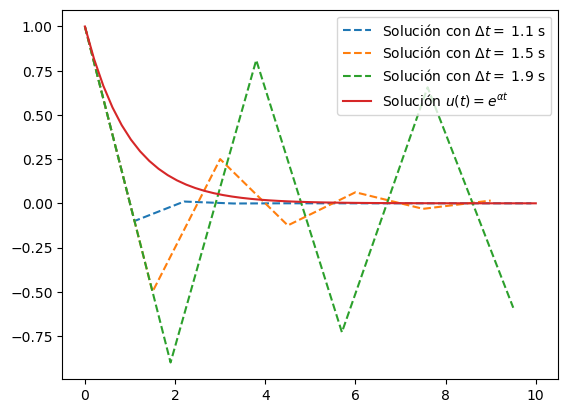

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dt = [1.1,1.5,1.9]
N = 100
alpha = -1
u = [np.zeros(N),np.zeros(N),np.zeros(N)]

ax = plt.subplot(1,1,1)



for j in range(len(dt)):
    for i in range(N-1):
        if i == 0:
            u[j][i] = 1
        u[j][i+1] = (1 + alpha*dt[j])*u[j][i]
    t = np.arange(0,10,dt[j])
    ax.plot(t,u[j][:len(t)],label=r"Solución con $\Delta t =$ %s s"%(dt[j]),linestyle="dashed")
tlins = np.linspace(0,10)
ax.plot(tlins,np.exp(alpha*tlins),label=r"Solución $u(t) = e^{\alpha t}$")

plt.legend()